In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\smrut\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Linear Regression
Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [2]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

we know in linear regression errors are normally distributed around the centre zero mean, and its standard deviation a positive real number.

Also we have a prior knowledge that slope and intercept are any real number. Seems like a good candidate for normal distribution (keeping standard deviation very large, i.e. we do not know their true mean in prior).

In [3]:
#defining prior
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    σ = pm.HalfCauchy("σ", 1, transform=None)

In [4]:
print(model.basic_RVs)
print(model.free_RVs)

[intercept, slope, σ]
[intercept, slope, σ]


In [5]:
#defining observed rv or likelihood function
with model:
    error = y - intercept - slope*x
    pm.Normal("error", 0, σ, observed=error)

In [6]:
print(model.basic_RVs)
print(model.observed_RVs)

[intercept, slope, σ, error]
[error]


In [7]:
with model:
    trace = pm.sample(draws=2000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, slope, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [02:10<00:00, 46.12draws/s]


In [8]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,0.781,0.174,0.470,1.119,0.004,0.003,1684.0,1684.0,1684.0,1805.0,1.0
slope,2.117,0.299,1.595,2.727,0.007,0.005,1694.0,1675.0,1693.0,1809.0,1.0
σ,0.597,0.062,0.487,0.711,0.001,0.001,1722.0,1670.0,1794.0,1649.0,1.0


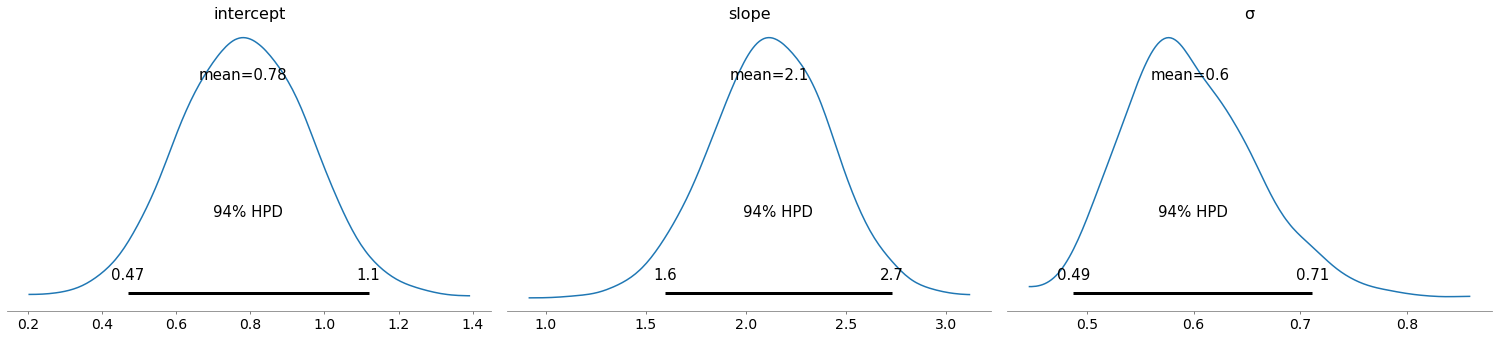

In [9]:
pm.plot_posterior(trace);

<Figure size 432x1008 with 0 Axes>

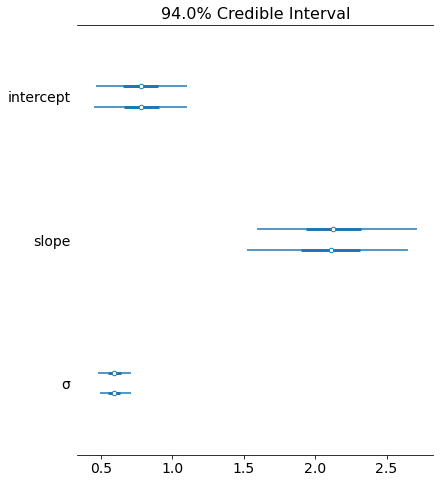

In [10]:
plt.figure(figsize=(6,14))
pm.forestplot(trace, var_names=["intercept", "slope", "σ"]);

The glm.linear_component() function can be used to generate the output variable y_est and coefficients of the specified linear model.

In [11]:
with pm.Model() as model:
    lm = pm.glm.LinearComponent.from_formula("y~x", data)
    σ = pm.HalfCauchy("σ", 1)
    y_obs = pm.Normal("y_obs", mu=lm.y_est, sigma=σ, observed=y)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, x, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [01:50<00:00, 108.41draws/s]


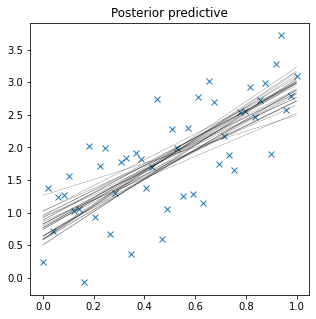

In [12]:
plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
pm.plot_posterior_predictive_glm(trace)

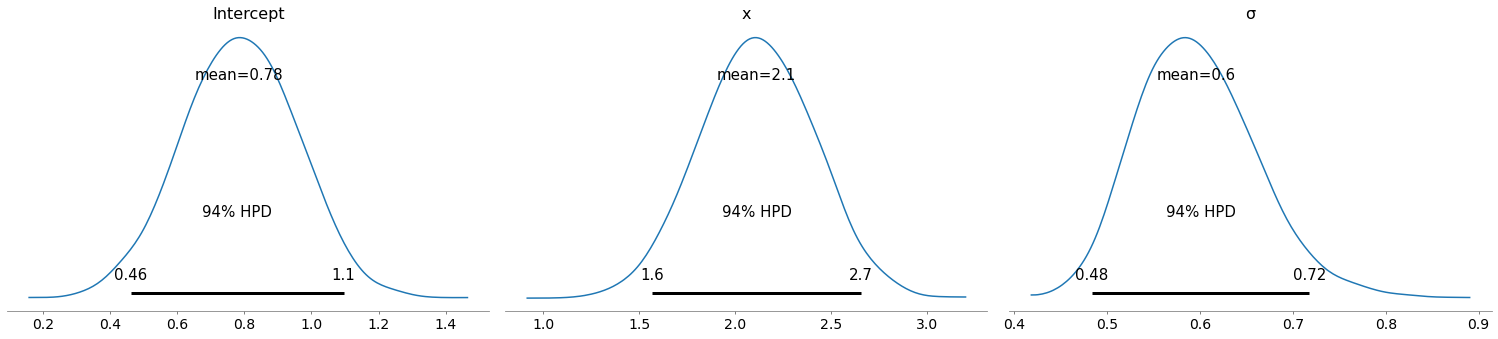

In [13]:
pm.plot_posterior(trace);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [02:33<00:00, 78.08draws/s] 


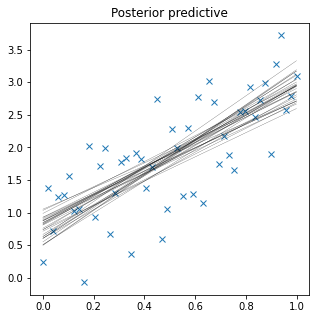

In [14]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
pm.plot_posterior_predictive_glm(trace)

# Robust GLM
Lets try the same model but with a few outliers in the data.

In [15]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:40<00:00, 49.75draws/s]


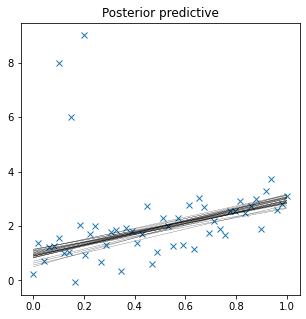

In [16]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT(link=pm.glm.families.Identity(),
                                   priors={'nu': 1.5,
                                           'lam': pm.Uniform.dist(0, 20)})
    pm.GLM.from_formula('y ~ x', data_outlier, family=family)
    trace = pm.sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
pm.plot_posterior_predictive_glm(trace)

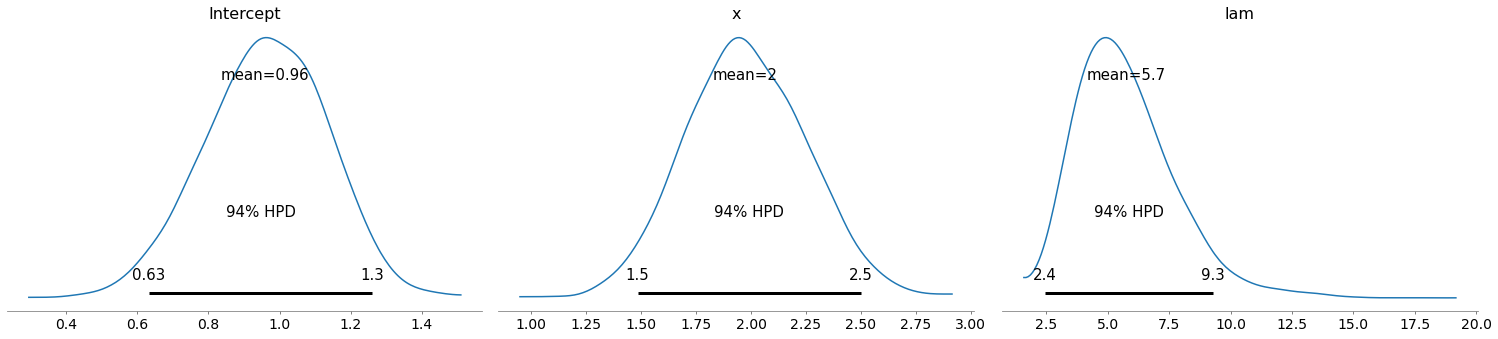

In [17]:
pm.plot_posterior(trace);

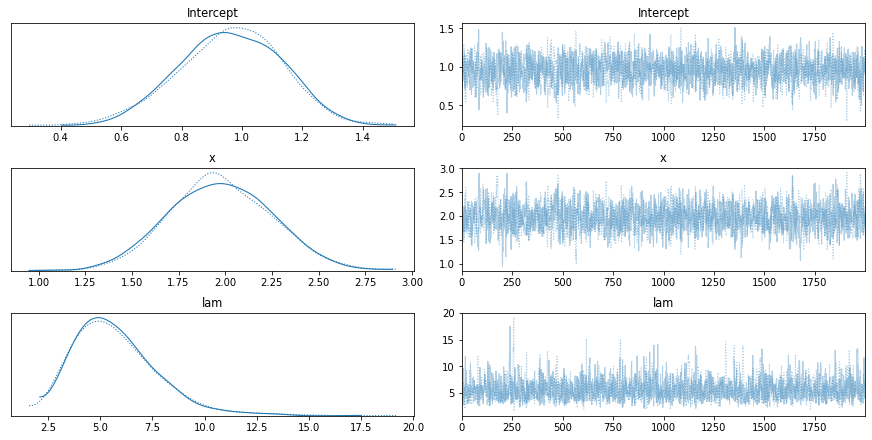

In [18]:
pm.traceplot(trace);

we know in linear regression errors are normally distributed around the centre zero mean, and its standard deviation a positive real number. However, StudentT distribution has a fatter tail, which nice model outlier. Hence, here we are assuming errors are StudentT distributed than Normal

In [24]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    lam = pm.Uniform("lam", 0, 20)
    error = y_out - intercept - slope*x_out
    pm.StudentT("error", nu=1.5, lam=lam, observed=error)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [03:59<00:00, 50.20draws/s]


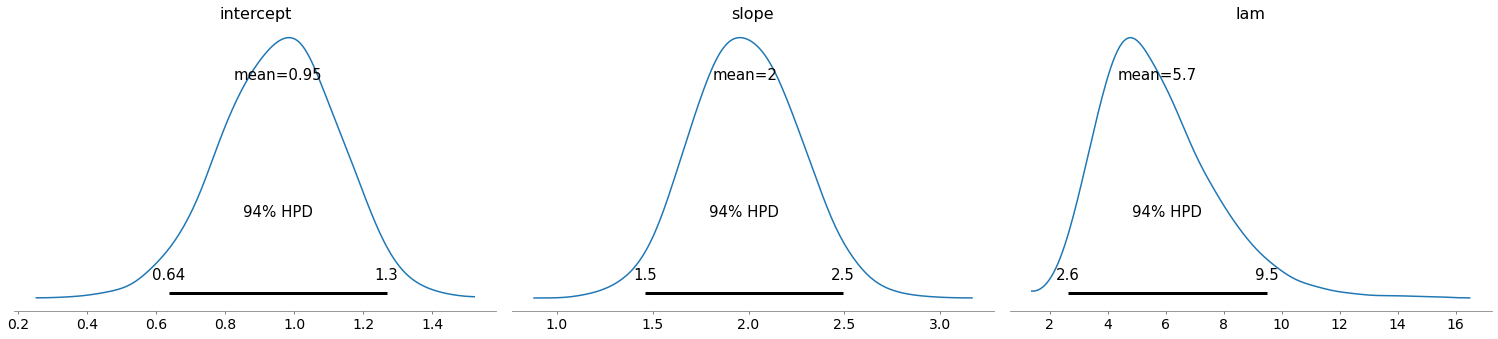

In [25]:
pm.plot_posterior(trace);

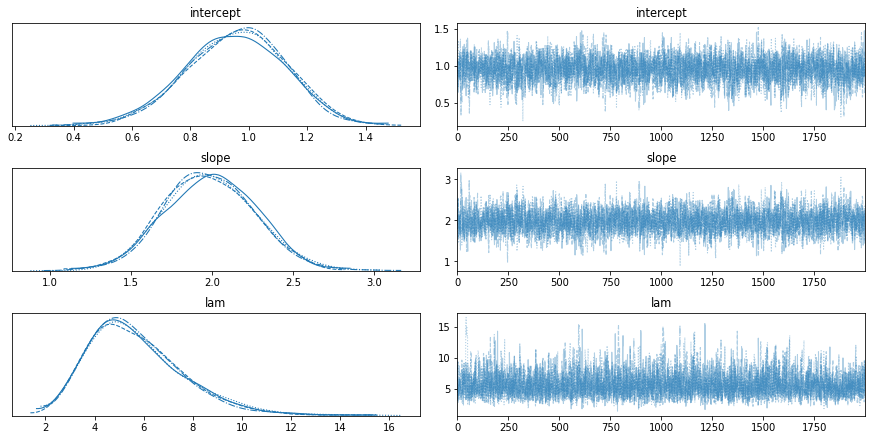

In [26]:
pm.traceplot(trace);

In [28]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    lam = pm.Uniform("lam", 0, 20)
    mu = intercept - slope*x_out
    pm.StudentT("y_out", nu=1.5, mu=mu, lam=lam, observed=y_out)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [04:17<00:00, 46.67draws/s]


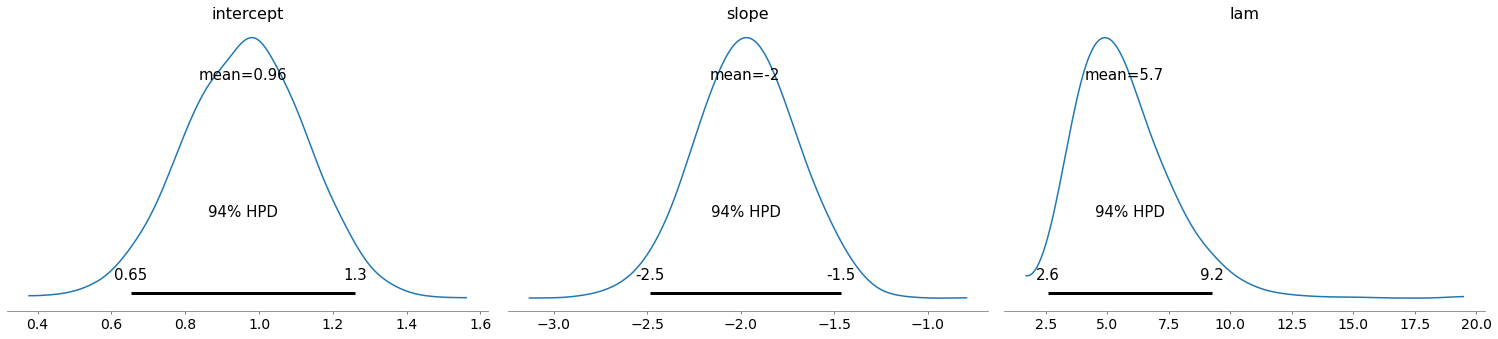

In [29]:
pm.plot_posterior(trace);

In [30]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    σ = pm.Uniform("σ", 0, 20)
    mu = intercept - slope*x_out
    pm.Normal("y_out", mu=mu, sigma=σ, observed=y_out)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [02:52<00:00, 69.70draws/s]


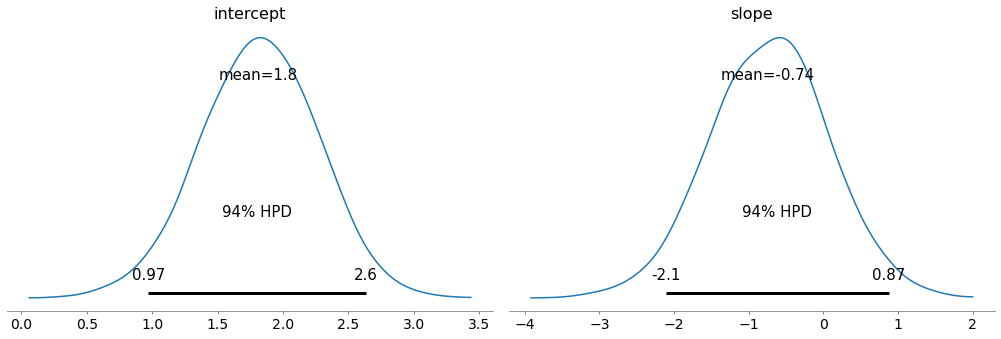

In [33]:
pm.plot_posterior(trace, ["intercept", "slope"]);

In [35]:
pm.backends.tracetab.trace_to_dataframe(trace)

,intercept,slope,σ
0,2.319044,0.295923,1.586385
1,2.433021,0.215730,1.629862
2,1.684769,-1.342327,1.583024
3,1.780372,-0.411498,1.600638
4,1.409327,-1.782640,1.722750
...,...,...,...
7995,1.772927,-0.905321,1.949231
7996,2.111416,0.285681,1.672795
7997,2.239536,0.293929,1.637274
7998,1.215725,-1.982436,1.908570
